# Notebook for calculations comparison

This notebook has the goal to compute the numerical calculations for the density contrast during a dust-flat bounce.


## Imports

In [1]:
import sys
import math
import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np
import scipy

from numcosmo_py import Nc, Ncm

%matplotlib inline

## Numcosmo Initialization

In [2]:
__name__ = "NcContext"

Ncm.cfg_init ()
Ncm.cfg_set_log_handler (lambda msg: sys.stdout.write (msg) and sys.stdout.flush ())

## Primordial black holes formation in  dust-flat bounce
In this notebook we develop the necessary objects to compute the power spectrum (and other observables) for magnetic field production in the contraction phase of a bouncing cosmology dominated by a dust-like fluid.
    The scale factor for this model is given by,
    \begin{equation},
    \frac{a(t)}{a_0} = \frac{1}{x_b}\left[1 + \left(\frac{t}{t_b}\right)^2\right]^{1/3}, \quad x \equiv \frac{a_0}{a}, \quad x_b \equiv \frac{a_0}{a_b}
    \end{equation} ,
    where $a_b$ gives the value of the scale factor at the bounce ($t = 0$), and $t_b$ the bounce time-scale. Solving the time $t$ in terms of the scale factor and substituting back to the Hubble function we can relate the free parameter $t_b$ with the dimensionless density $\Omega_m$, i.e.
    \begin{equation}
H^2 = \left(\frac{c \dot a}{a}\right)^2 = \frac{4c^2}{9}\frac{x^3}{t_b^2x_b^3} - \frac{4c^2}{9}\frac{x^6}{t_b^2x_b^6} = \frac{1}{R_H^2}\left(\Omega_m x^3 + \Omega_Q x^6\right) \quad\Rightarrow\quad t_b = \frac{2}{3}\frac{R_H}{\sqrt{\Omega_m x_b^3}}, \quad \Omega_Q = - \frac{\Omega_m}{x_b^3}.
\end{equation},
    where $R_H \equiv c/H_0$ is the Hubble radius today and $\Omega_m$ is the dimensionless matter density today.
    From here on we will express everything in unit of the Hubble radius, $t \to t /R_H$ and $t_b \to t_b / R_H$. 

## Definition of the Numerical Object to compute the equations of motion

### Equations of motion to be solved
This is a python object to solve the equation of motion for zeta, which is
    \begin{equation}
    2 z^2 \dot{\zeta}_{ka} = \Pi_{\zeta, ka}
    \end{equation}
    \begin{equation}
    \dot{\Pi}_{\zeta, ka} = 2 \frac{ka^2}{a^2} w z^2 \zeta_{ka}
 .\end{equation}
In this system, I am using cosmic time. However, we are writting everything in units of $RH$. I am using the dimensionless fields and the dimensionless momentum as $ka = k * RH$. Also here a dot is the derivative of time and im using N=1 and the metric $-dt^2$, so time has the dimension of space.

In [3]:
class PyCSQ1DVecPert (Ncm.CSQ1D):
    def __init__ (self, Omega_m = 0.3, Omega_r = 8.0e-5, xb = 1.0e25, b = 1.0e-6, h = 0.7):
        Ncm.CSQ1D.__init__ (self)

        self.Omega_m = Omega_m
        self.Omega_r = Omega_r
        self.xb      = xb
        self.b       = b
        self.RH      = (Ncm.C.c () / (1.0e5 * h)) # Hubble radius in units of Mpc
        self.RH_m      = (Ncm.C.c () * 3.086e22 / (1.0e5 * h)) # Hubble radius in units of m
        self.gamma   = 0.25 * xb * Omega_m
        self.tb    = 2.0 / (3.0* math.sqrt (Omega_m * xb**3))
        self.lp_RH   = 1.0 / (Ncm.C.hubble_radius_hm1_planck () / h)
        self.hbar = self.lp_RH**2 * Ncm.C.c()**3 / Ncm.C.G()

    
    def y_t (self, t):
        t2  = t * t
        tb2 = self.tb**2
        s    = math.pow((1.0 + t2 / tb2),  1.0/(3.0 * (1.0 + self.b)))

        return s / self.xb

    def t_y (self, y):
        xb   = self.xb
        yxb3 = math.pow(y * xb, 3)
        s1   = yxb3 - 1

        return math.sqrt (s1) * self.etab

    def H_t (self, t):
        t2  = t * t
        tb2 = self.tb**2
        s    = math.pow((1.0 + t2 / tb2),  1.0/(3.0 * (1.0 + self.b)))
        xb   = self.xb
        y_t  = s / xb

        x = 1.0/ y_t
        x3 = x**3
        x6 = x**6
        m1    = (4.0/9.0) * (xb**(-3) / tb2)
        s1 = m1*( x3 - x6/ (xb**3))
        return math.sqrt(s1)

    def H_dt(self, t):
        t2  = t * t
        tb2 = self.tb**2
        s    = math.pow((1.0 + t2 / tb2),  1.0/(3.0 * (1.0 + self.b)))
        xb   = self.xb
        y_t  = s / xb
        x = 1.0/y_t
        x3 = x**3
        x6 = x**6
        tb2 = self.tb**2
        m1    = (2.0/9.0) * (xb**(-3) / tb2)
        return m1 * ( - 3.0 * x3 + 6 * x6/ (xb**3))

    def H_d2t(self, t):
        t2  = t * t
        tb2 = self.tb**2
        s    = math.pow((1.0 + t2 / tb2),  1.0/(3.0 * (1.0 + self.b)))
        xb   = self.xb
        y_t  = s / xb
        x = 1.0/y_t

        x3 = x**3
        x6 = x**6
        mh    = (4.0/9.0) * (xb**(-3) / tb2)
        sh = mh*( x3 - x6/ (xb**3))
        H = math.sqrt(sh)
        m1    = 2.0 * H * (xb**(-3) / tb2)

        return m1 * ( x3 - 4.0 * x6/ (xb**3))

    def H_d3t(self, t):
        t2  = t * t
        tb2 = self.tb**2
        s    = math.pow((1.0 + t2 / tb2),  1.0/(3.0 * (1.0 + self.b)))
        xb   = self.xb
        y_t  = s / xb
        x = 1.0/y_t

        x3 = x**3
        x6 = x**6
        mh    = (4.0/9.0) * (xb**(-3) / tb2)
        sh = mh*( x3 - x6/ (xb**3))
        mh2t    = 2.0 * H * (xb**(-3) / tb2)
        mht    = (2.0/9.0) * (xb**(-3) / tb2)

        H = math.sqrt(sh)
        H_dt =  mht * ( - 3.0 * x3 + 6 * x6/ (xb**3))
        H_d2t =  mh2t * ( x3 - 4.0 * x6/ (xb**3))



        m1    = 2.0 * H**2 * (xb**(-3) / tb2)

        return (H_dt * H_d2t / H) + m1 * ( -3.0*x3 + 24.0 * x6/ (xb**3))


    def z_y(self, t):
        t2  = t * t
        tb2 = self.tb**2
        s    = math.pow((1.0 + t2 / tb2),  1.0/(3.0 * (1.0 + self.b)))
        xb   = self.xb
        y_t  = s / xb
        y_t3 = y_t**3

        return math.sqrt((3.0 /2.0) * y_t3 * ((1.0 + self.b) / self.b))
    
    def z_dt(self, t):
        t2  = t * t
        tb2 = self.tb**2
        s    = math.pow((1.0 + t2 / tb2),  1.0/(3.0 * (1.0 + self.b)))
        xb   = self.xb
        y_t  = s / xb
        y_t3 = y_t**3
        x = 1.0/y_t
        x3 = x**3
        x6 = x**6
        tb2 = self.tb**2
        m1    = (2.0/9.0) * (xb**(-3) / tb2)
        H = m1 * ( - 3.0 * x3 + 6 * x6/ (xb**3))

        z_y = math.sqrt((3.0 /2.0) * y_t3 * ((1.0 + self.b) / self.b))
        
        return (3.0/2.0) * z_y * H  

    def z_d2t(self,t):
        t2  = t * t
        tb2 = self.tb**2
        s    = math.pow((1.0 + t2 / tb2),  1.0/(3.0 * (1.0 + self.b)))
        xb   = self.xb
        y_t  = s / xb
        y_t3 = y_t**3
        z_y= math.sqrt((3.0 /2.0) * y_t3 * ((1.0 + self.b) / self.b))
        m1 = (3.0 / 2.0 )

        x = 1.0/y_t
        x3 = x**3
        x6 = x**6
        mht = (2.0/9.0) * (xb**(-3) / tb2)
        mh = (4.0/9.0) * (xb**(-3) / tb2)
        sh = mh*( x3 - x6/ (xb**3))

        H2 = sh
        H_dt =  mht * ( - 3.0 * x3 + 6 * x6/ (xb**3))


        return m1 * z_y * (3.0 * H2 / 2.0 + H_dt) 

    def z_d3t(self,t):
        t2  = t * t
        tb2 = self.tb**2
        s    = math.pow((1.0 + t2 / tb2),  1.0/(3.0 * (1.0 + self.b)))
        xb   = self.xb
        y_t  = s / xb
        y_t3 = y_t**3
        z_y= math.sqrt((3.0 /2.0) * y_t3 * ((1.0 + self.b) / self.b))
        m1 = (3.0 / 2.0 )

        x = 1.0/y_t
        x3 = x**3
        x6 = x**6
        mh    = (4.0/9.0) * (xb**(-3) / tb2)
        sh = mh*( x3 - x6/ (xb**3))
        mht    = (2.0/9.0) * (xb**(-3) / tb2)

        H = math.sqrt(sh)
        mh2t    = 2.0 * H * (xb**(-3) / tb2)
        H3 = H**3
        H_dt =  mht * ( - 3.0 * x3 + 6 * x6/ (xb**3))
        H_d2t =  mh2t * ( x3 - 4.0 * x6/ (xb**3))


        return m1 * z_y * (9.0 * H3 / 4.0 + (9.0 / 2.0) * H_dt * H + H_d2t) 

    def z_d4t(self,t):
        t2  = t * t
        tb2 = self.tb**2
        s    = math.pow((1.0 + t2 / tb2),  1.0/(3.0 * (1.0 + self.b)))
        xb   = self.xb
        y_t  = s / xb
        y_t3 = y_t**3
        z_y= math.sqrt((3.0 /2.0) * y_t3 * ((1.0 + self.b) / self.b))
        m1 = (3.0 / 2.0 )

        x = 1.0/y_t
        x3 = x**3
        x6 = x**6
        tb2 = self.tb**2
        mh    = (4.0/9.0) * (xb**(-3) / tb2)
        sh = mh*( x3 - x6/ (xb**3))
        mht    = (2.0/9.0) * (xb**(-3) / tb2)

        H = math.sqrt(sh)
        mh2t    = 2.0 * H * (xb**(-3) / tb2)
        mh3t    = 2.0 * H**2 * (xb**(-3) / tb2)
        H2 = H**2
        H4 = H**4
        H_dt =  mht * ( - 3.0 * x3 + 6 * x6/ (xb**3))
        H_d2t =  mh2t * ( x3 - 4.0 * x6/ (xb**3))
        H_d3t (H_dt * H_d2t / H) + mh3t * ( -3.0*x3 + 24.0 * x6/ (xb**3))

        return m1 * z_y * (27.0 * H4 / 4.0 + (27.0 / 2.0) * H_dt * H2 + (9.0/2.0) * H_dt**2 + 6.0 * H_d2t * H + H_d3t) 

    def do_eval_xi (self, model, t, k):
        k2 = k**2
        t2  = t * t
        tb2 = self.tb**2
        s    = math.pow((1.0 + t2 / tb2),  1.0/(3.0 * (1.0 + self.b)))
        xb   = self.xb
        y_t  = s / xb
        y_t2  = y_t**2
        y_t3 = y_t**3
        z_y= math.sqrt((3.0 /2.0) * y_t3 * ((1.0 + self.b) / self.b))

        nu = math.sqrt(k2 * self.b / y_t2)
        m = 2.0 * z_y**2
        
        
        return np.log(m * nu)

    def do_eval_nu (self, model, t, k):
        k2 = k**2
        t2  = t * t
        tb2 = self.tb**2
        s    = math.pow((1.0 + t2 / tb2),  1.0/(3.0 * (1.0 + self.b)))
        xb   = self.xb
        y_t  = s / xb
        y_t2  = y_t**2
        y_t3 = y_t**3
        z_y= math.sqrt((3.0 /2.0) * y_t3 * ((1.0 + self.b) / self.b))
        
        return math.sqrt(k2 * self.b / y_t2)
        


    def do_eval_F1 (self, model, t, k):
        k2 = k**2
        t2  = t * t
        tb2 = self.tb**2
        s    = math.pow((1.0 + t2 / tb2),  1.0/(3.0 * (1.0 + self.b)))
        xb   = self.xb
        y_t  = s / xb
        y_t2  = y_t**2
        y_t3 = y_t**3
        z_y= math.sqrt((3.0 /2.0) * y_t3 * ((1.0 + self.b) / self.b))

        x = 1.0/y_t
        x3 = x**3
        x6 = x**6
        mht = (2.0/9.0) * (xb**(-3) / tb2)
        mh = (4.0/9.0) * (xb**(-3) / tb2)
        sh = mh*( x3 - x6/ (xb**3))

        
        nu = math.sqrt(k2 * self.b / y_t2)
        
        H = math.sqrt(sh)

        return H / nu

    def do_eval_F2 (self, model, t, k):
        k2 = k**2
        t2  = t * t
        tb2 = self.tb**2
        s    = math.pow((1.0 + t2 / tb2),  1.0/(3.0 * (1.0 + self.b)))
        xb   = self.xb
        y_t  = s / xb
        y_t2  = y_t**2
        y_t3 = y_t**3
        z_y= math.sqrt((3.0 /2.0) * y_t3 * ((1.0 + self.b) / self.b))

        x = 1.0/y_t
        x3 = x**3
        x6 = x**6
        mht = (2.0/9.0) * (xb**(-3) / tb2)
        mh = (4.0/9.0) * (xb**(-3) / tb2)
        sh = mh*( x3 - x6/ (xb**3))

        H = math.sqrt(sh)
        nu = math.sqrt(k2 * self.b / y_t2)
        F1 = H / nu
        H_dt =  mht * ( - 3.0 * x3 + 6 * x6/ (xb**3))
        
        
        return 0.5 * F1 * F1 + 0.5 * H_dt / (nu**2)

    def do_prepare (self, model):
        pass 



## Initialize the numerical object

Here, $b$ is the equations of state for dark matter and $xb = \frac{a_0}{a_b}$ where the index $b$ indicates the variable computed at the bounce.

In [4]:
csq1d = PyCSQ1DVecPert (b = 1.0e-6, xb = 5.0e25)
momenta_rh = np.geomspace(1.0e4, 1.0e9, 4)

### Conversions
Multiply by these values to convert from a to b (conv_a_b).

Since the analitical computations are in natural units, we need to convert our results to compare both approaches.

In [40]:
conv_tn_t =  6.58e-25 #tn to cosmic time
conv_trh_t = csq1d.RH_m / Ncm.C.c() #t_rh to cosmic time
conv_taun_tau = (0.197e-15) # conformal time in natural units to meters
conv_taun_taurh = (0.197e-15) / csq1d.RH_m # conformal time in natural units to units in RH
conv_deltak_mpc_to_m = (3.08e22)**(3/2) # deltak in MPC to meters
conv_deltan_delta =(0.197e-15)**(3/2)  #deltak in natural units to meters
conv_Hrh_Hn = 0.197e-15/ csq1d.RH_m
#conv_Hrh_Hn = (6.58e-25) * csq1d.RH_m/ Ncm.C.c()  
conv_Hrh_HMpc = 0.197e-15/ csq1d.RH
conv_knat_krh = csq1d.RH_m / (0.197e-15)
conv_tbnat_tbrh =  0.197e-15/ csq1d.RH_m

## Comparison of $T_b$, $a_b$

In [41]:
print(conv_tbnat_tbrh)
tb_nat = csq1d.tb / (Ncm.C.c() * conv_tbnat_tbrh)
print(f'The numerical value of xb is {csq1d.xb:22.15e}, the analitical value of xb is ={1.0e17}\n \n Numerical Tb = {csq1d.tb:22.15e} RH, which in natural units is {tb_nat:22.15e}')

1.4905537500915476e-42
The numerical value of xb is  5.000000000000000e+25, the analitical value of xb is =1e+17
 
 Numerical Tb =  3.442651863295482e-39 RH, which in natural units is  7.704150580224699e-06


## Time Conversion
We will compute everything for a given time. Thus we must make the conversion from both units. It is important to notice that while the numerical computations depend on a time t, the analitical computations uses the conformal time tau

### Values found by Eduardo

In [7]:
print(f'The conformal time we want to find is taun = (10^19 * Tb) in natural units, which in RH units is tau = {10**19 * tb_nat * conv_taun_taurh} R_H')

times = [-1.0e-23, -1.0e-26, -1.0e-28,-1.0e-30, -1.49e-56, -1.52e-21 ]
def intp(t):
    return  1.0 / csq1d.y_t(t)
for t in times:
    integral = scipy.integrate.quad(intp, 0, t)[0]
t_converted_num = times[-1]
print(f'The time is t={times[-1]} R_H in my units, which led to the value of tau = {integral:22.15e} R_H')

The conformal time we want to find is taun = (10^19 * Tb) in natural units, which in RH units is tau = 3.4426518632954816e-20 R_H
The time is t=-1.52e-21 R_H in my units, which led to the value of tau = -3.932288934038186e-07 R_H


### Values found in overleaf

In [8]:
t_cosmic = -37045.3 * tb_nat * conv_tn_t
trh_converted_overleaf = t_cosmic / conv_trh_t 
print(f'The time from overleaf is {trh_converted_overleaf} R_H')

The time from overleaf is -1.2770461543430062e-34 R_H


## Scales Conversion

We want to compute everything between the jeans and the Hubble scale. Let us check their values.

### Natural Units


In [9]:
tl = -1.0e-21
H_natural = csq1d.H_t(tl)  * conv_Hrh_Hn
H_rh = csq1d.H_t(tl) * csq1d.RH
kj_natural = csq1d.y_t(tl) * H_natural * math.sqrt(3.0/2.0) /  math.sqrt(csq1d.b)
kh_natural = csq1d.y_t(tl) *  H_natural
r_nat = math.pi /kj_natural

kj_rh = kj_natural * conv_knat_krh
kh_rh = kh_natural * conv_knat_krh
r_nat = math.pi / kj_natural

print(f'In natural units, the kj_nat = {kj_natural} and kh_nat =  {kh_natural}')

In natural units, the kj_nat = 1.0676012918491651e-32 and kh_nat =  8.716928045888668e-36


### RH units

In [10]:
kj_rh = kj_natural * conv_knat_krh
kh_rh = kh_natural * conv_knat_krh
print(f'In RH  units, the kj_rh = {kj_rh:22.15e} RH^-1 and kh_rh =  {kh_rh:22.15e} RH^{-1}')

In RH  units, the kj_rh =  7.162447458091294e+09 RH^-1 and kh_rh =   5.848113860606025e+06 RH^-1


## Scale Factor Plot

We want to compare the scale factor found with the numerical and the analitical computaions.

### Analitical Scale factor

In [11]:
def do_a_ab(t): ## Eq 146 from overleaf. The time should be in cosmic time  in natural units
    return (t /tb_nat)**(2/(3*(1 - csq1d.b)))



Analitical values for a/ab: [9.441405633326588e+18, 4.6697877448669466e+17, 2034057957695.7036]
Numerical values for a/ab:[9.44899501554392e+18, 4.673569611164741e+17, 2035755514473.5156]


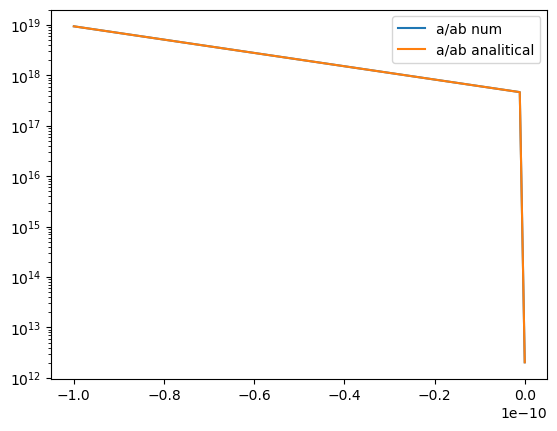

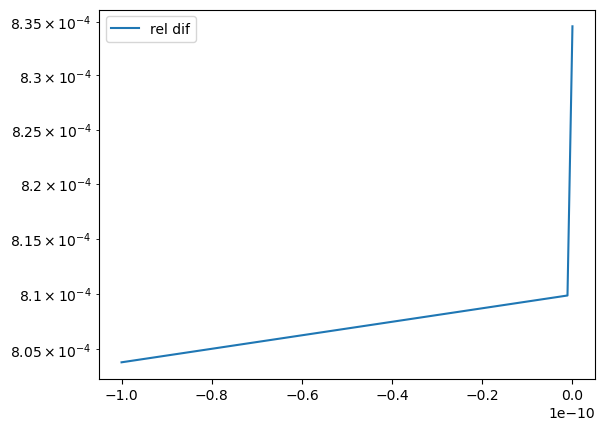

In [12]:
times = [-1.0e-10, -1.1e-12,-1.0e-20]
t_natural = []


a_ab_analitical_l = []
a_ab_num_l = []
for t_rh in times:
    def intp(t):
        return  1.0 / csq1d.y_t(t)
    t_cosmic = -t_rh * conv_trh_t 
    t_cosmic_nat = (t_cosmic ) / conv_tn_t
    tau_nat = scipy.integrate.quad(intp, 0, t_rh)[0] / conv_taun_taurh
    #print(f'natural time is {t_nat:22.15e}')
    a_ab_analitical_l.append(do_a_ab(t_cosmic_nat))
    a_ab_num_l.append(csq1d.y_t(t_rh) * csq1d.xb)
#plt.plot(times, a_over_l)
#plt.show()
print(f'Analitical values for a/ab: {a_ab_analitical_l}\nNumerical values for a/ab:{a_ab_num_l}')
plt.plot(times, a_ab_num_l, label='a/ab num')
plt.plot(times, a_ab_analitical_l, label='a/ab analitical')
plt.yscale('log')
plt.legend()
plt.show()
plt.plot(times, np.abs(np.array(a_ab_num_l)/ np.array(a_ab_analitical_l) - 1), label='rel dif')
plt.yscale('log')
plt.legend()
plt.show()

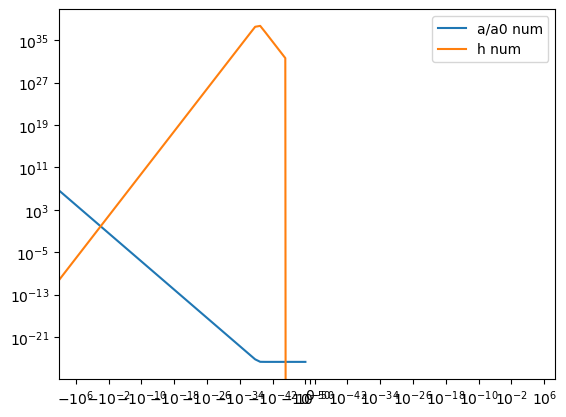

0.666725712273288


In [13]:
times =np.geomspace(-1.0e10, -1.0e-50, 50) 
t_natural = []

h_num_l = []
a_ab_analitical_l = []
a_ab_num_l = []
for t_rh in times:
    def intp(t):
        return  1.0 / csq1d.y_t(t)
    t_cosmic = -t_rh * conv_trh_t 
    t_cosmic_nat = (t_cosmic ) / conv_tn_t
    tau_nat = scipy.integrate.quad(intp, 0, t_rh)[0] / conv_taun_taurh
    #print(f'natural time is {t_nat:22.15e}')
    a_ab_num_l.append(csq1d.y_t(t_rh))
    h_num_l.append(csq1d.H_t(t_rh))
#plt.plot(times, a_over_l)
#plt.show()

plt.plot(times, a_ab_num_l, label='a/a0 num')
plt.plot(times, h_num_l, label='h num')

plt.yscale('log')
plt.xscale('symlog', linthresh=1.0e-50)
plt.legend()
plt.show()
print(csq1d.H_t(-1.0))

In [14]:
def do_H_nat(tau):
    return  2 / (-tau) 

In [15]:
times = [-1.0e-10, -1.1e-12,-1.0e-20]
t_natural = []


H_analitical_l = []
H_num_l = []
for t_rh in times:
    def intp(t):
        return  1.0 / csq1d.y_t(t)
    t_cosmic = -t_rh * conv_trh_t 
    t_cosmic_nat = (t_cosmic ) / conv_tn_t
    tau_nat = scipy.integrate.quad(intp, 0, t_rh)[0] / conv_taun_taurh
    print(do_H_nat(tau_nat), conv_Hrh_Hn * csq1d.H_t(t_rh) * csq1d.y_t(t_rh))
    

1.877901749794276e-39 1.878021072953512e-39
8.443903809254512e-39 8.44440225754747e-39
4.0458787802240094e-36 4.046042693568523e-36


### Compare zeta_k^2

I want to check if the definitions of our fields are the same. First let us check the definitions of the modes $|\zeta_k^2|$.

In [16]:
###EQ under 155. There is a sqrt(2) factor that differs from the mass that I am using. So i will add this factor
##Everythins is in units of MPC
def do_analitical_zeta(t_rh, k_rh):
    cs = math.sqrt(csq1d.b)
    lp = csq1d.lp_RH * csq1d.RH
    k = k_rh / csq1d.RH
    const = math.sqrt(8 * math.pi * csq1d.b / (3 * (1 + csq1d.b)))
    mult = 1 / ((csq1d.y_t(t_rh)))
    tk = 1 / (math.sqrt(2 * cs * k))
    
    return  lp  * const * mult * tk


For k_rh = 10000.0 RH^-1, the values in units of $[|\zeta_k^2|]$ = Mpc^1.5 is

zeta_k2_analitical:[1.399754752400203e-119, 1.5043892731026254e-119, 1.6235232364716858e-119, 1.7602078471398836e-119, 1.9183851531790523e-119, 2.1032312398324734e-119, 2.3216686231660447e-119, 2.5831525665031247e-119, 2.9009164680773034e-119, 3.2940180727201997e-119, 3.7908499238169075e-119, 4.435481230787042e-119, 5.299859655543666e-119, 6.509207846801702e-119, 8.300515995414328e-119, 1.1176901042396552e-118, 1.6402550264518783e-118, 2.8165002875684917e-118, 7.097635023581209e-118, 1.3997283802278143e-112] 

zeta_k2_num: [1.3999318675278568e-119, 1.5053622465481327e-119, 1.623780918650257e-119, 1.7613601205350988e-119, 1.9189255456518676e-119, 2.1042653245909417e-119, 2.3231696005301127e-119, 2.5838335263806734e-119, 2.902696417730111e-119, 3.296720010374505e-119, 3.79311605761479e-119, 4.437503820350651e-119, 5.302437071092492e-119, 6.512908657935903e-119, 8.307031474515188e-119, 1.1191609118766937e-118, 

<>:41: SyntaxWarning: invalid escape sequence '\z'
<>:44: SyntaxWarning: invalid escape sequence '\z'
<>:41: SyntaxWarning: invalid escape sequence '\z'
<>:44: SyntaxWarning: invalid escape sequence '\z'
/tmp/ipykernel_3640/763150072.py:41: SyntaxWarning: invalid escape sequence '\z'
  plt.ylabel('$\zeta_k^2$ [$Mpc^{3/2}]$')
/tmp/ipykernel_3640/763150072.py:44: SyntaxWarning: invalid escape sequence '\z'
  print(f'For k_rh = {k_rh} RH^{-1}, the values in units of $[|\zeta_k^2|]$ = Mpc^{3/2} is\n')


For k_rh = 21544346.900318865 RH^-1, the values in units of $[|\zeta_k^2|]$ = Mpc^1.5 is

zeta_k2_analitical:[1.3998291481049842e-109, 1.5044692300369948e-109, 1.6236095252676881e-109, 1.7603014005982521e-109, 1.9184871136166969e-109, 2.1033430246703947e-109, 2.321792017750472e-109, 2.5832898587186244e-109, 2.901070649151022e-109, 3.2941931467802815e-109, 3.7910514040279733e-109, 4.435716972549628e-109, 5.300141338206384e-109, 6.509553805173318e-109, 8.300957160094478e-109, 1.1177495084134072e-108, 1.6403422044275289e-108, 2.8166499817432955e-108, 7.098012255000174e-108, 1.3998056810659027e-102] 

zeta_k2_num: [1.4000062884341223e-109, 1.5054422972963041e-109, 1.6238671044828027e-109, 1.7614541142600592e-109, 1.9190268863445356e-109, 2.1043783173809614e-109, 2.323292079254759e-109, 2.583970738306531e-109, 2.902852504092778e-109, 3.29689442331486e-109, 3.793314891498466e-109, 4.43773750903216e-109, 5.302718349654504e-109, 6.513252542513952e-109, 8.307463076296645e-109, 1.119220152152443

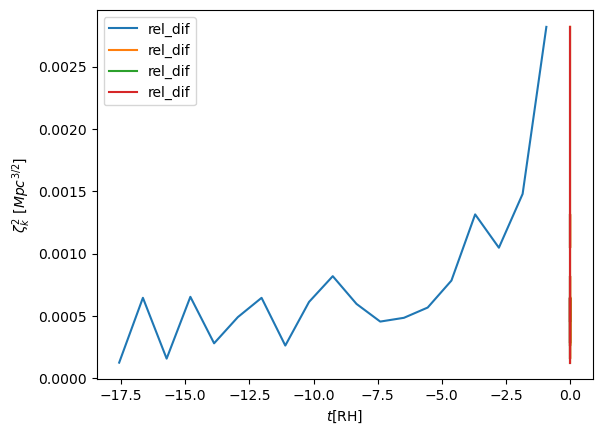

In [17]:
from mpmath import mp
import mpmath
for k_rh in momenta_rh:
    var = []
    beta = []
    max_etaf = -1.0e300
    min_etai = +1.0e300
    csq1d.set_reltol(1.0e-5)
    csq1d.set_k (k_rh)
    (Found1, etai) = csq1d.find_adiab_time_limit(None, -1.0e15, -1.0e-25, 1.0e-7)
    (Found2, etafa) = csq1d.find_adiab_time_limit(None, +1.0e-25, +1.0e15, 1.0e0)
    etaf = etafa
    assert Found1
    assert Found2


    csq1d.set_ti (etai)
    csq1d.set_tf (etaf)
    csq1d.set_init_cond_adiab (None, etai)
    csq1d.prepare (None)
    t_a, t_s = csq1d.get_time_array ()
    zeta2_k_anali = []
    zeta2_k_num = []
    t_a = np.linspace(t_a[0], t_a[-1], 20)
    for t_rh in t_a:
        (J11, J12, J22) = csq1d.get_J_at (None, t_rh)
        f11 = 0.5 * 8.0 * math.pi * csq1d.lp_RH**2 * csq1d.RH**3 
        f22 = 0.5 * 8.0 * math.pi * csq1d.lp_RH**2 * csq1d.RH
        f12 = 0.5 * 8.0 * math.pi * csq1d.lp_RH**2 * csq1d.RH**2
        fv =  1.0#csq1d.RH**3
        J11D = J11 * f11
        J22D = J22 * f22
        J12D = J12 * f12
        zeta_k_over = do_analitical_zeta(t_rh, k_rh)
        zeta2_k_anali.append(zeta_k_over**2)
        zeta2_k_num.append(J11D)
    reldif = abs(((np.array(zeta2_k_num) - np.array(zeta2_k_anali))) /np.array(zeta2_k_anali) )
    #plt.plot(eta_a, zeta2_k_anali, label=f'k{k:22.15e}, analitical' )
    #plt.plot(eta_a, zeta2_k_num, label= f'k{k:22.15e}, num' )
    plt.plot(t_a[:-1], reldif[:-1], label='rel_dif')
    plt.ylabel('$\zeta_k^2$ [$Mpc^{3/2}]$')
    plt.xlabel('$t$[RH]')
    plt.legend()
    print(f'For k_rh = {k_rh} RH^{-1}, the values in units of $[|\zeta_k^2|]$ = Mpc^{3/2} is\n')
    print(f'zeta_k2_analitical:{zeta2_k_anali} \n\nzeta_k2_num: {zeta2_k_num}\n')



### Compare phi_k^2

We now want to compare the mode $|\phi_k^2|$

In [18]:
###EQ under 183
##Everythins is in units of MPC
#There is a factor of 3 different, probably from 2.27 in my overleaf
def do_analitical_phi(t_rh, k_rh):  
    cs = math.sqrt(csq1d.b)
    lp = csq1d.lp_RH * csq1d.RH
    k = k_rh / csq1d.RH
    def intp(t):
        return 1/csq1d.y_t(t)
    nu = (csq1d.b * 3 + 5) / (2 * (1 + 3 * csq1d.b))
    tau_rh = scipy.integrate.quad(intp, 0, t_rh)[0]
    arg = -cs * tau_rh * k_rh
    hv = scipy.special.hankel1(nu, arg)
    a = csq1d.y_t(t_rh)
    tau = tau_rh * csq1d.RH
    Mpl = 1 / (math.sqrt(8 * math.pi) * lp)
    #Mpl = 1 / (lp)
    pl_factor =  1/( 2**(3/2) * Mpl )

    tf =   hv / (math.sqrt(abs(tau))  * k * a)
    const = math.sqrt(6 * math.pi *(1+cs**2))
    mult = 1 / (1+3*cs**2)
    
    phik =   pl_factor * const * mult * tf
    return math.sqrt(abs(phik*phik))

<>:43: SyntaxWarning: invalid escape sequence '\p'
<>:46: SyntaxWarning: invalid escape sequence '\p'
<>:43: SyntaxWarning: invalid escape sequence '\p'
<>:46: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_3640/1959647566.py:43: SyntaxWarning: invalid escape sequence '\p'
  plt.ylabel('$\phi_k^2$ [$Mpc^{3/2}]$')
/tmp/ipykernel_3640/1959647566.py:46: SyntaxWarning: invalid escape sequence '\p'
  print(f'For k_rh = {k_rh} RH^{-1}, the values in units of [|\phi_k^2|] = Mpc^{3/2} is\n')


For k_rh = 10000.0 RH^-1, the values in units of [|\phi_k^2|] = Mpc^1.5 is

phi2_k_analitical:[1.593684385430925e-122, 1.7757050508116172e-122, 1.9907876490688017e-122, 2.247452273146466e-122, 2.5571513783752517e-122, 2.9355697911182604e-122, 3.404650370051719e-122, 3.9958480386599767e-122, 4.755543547907971e-122, 5.75442515696157e-122, 7.104546497001056e-122, 8.992177231055458e-122, 1.1745668379082608e-121, 1.5988519484746253e-121, 2.302606871743336e-121, 3.5983953941272777e-121, 6.398713084219837e-121, 1.4403430565982312e-120, 5.767763692190405e-120, 1.8332071545071082e-111] 

phi2_k_num: [1.5939792171035014e-122, 1.77511859818577e-122, 1.9911064276351246e-122, 2.2467274274103835e-122, 2.557256972119714e-122, 2.935160139817611e-122, 3.403598195859402e-122, 3.996210885715842e-122, 4.7544301700165307e-122, 5.751855520742309e-122, 7.102980234330073e-122, 8.99167936056315e-122, 1.1744985723319323e-121, 1.5986669858196939e-121, 2.3018946619479673e-121, 3.595588516441622e-121, 6.3959380193

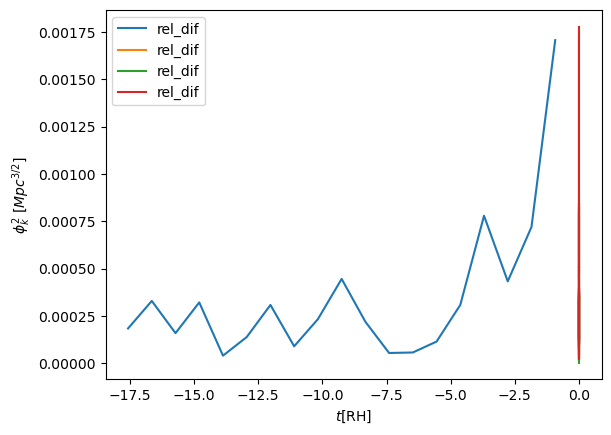

In [19]:
from mpmath import mp
import mpmath
for k_rh in momenta_rh:
    var = []
    beta = []
    max_etaf = -1.0e300
    min_etai = +1.0e300
    csq1d.set_reltol(1.0e-5)
    csq1d.set_k (k_rh)
    (Found1, etai) = csq1d.find_adiab_time_limit(None, -1.0e15, -1.0e-25, 1.0e-7)
    (Found2, etafa) = csq1d.find_adiab_time_limit(None, +1.0e-25, +1.0e15, 1.0e0)
    etaf = etafa
    assert Found1
    assert Found2

    phi2_k_anali = []
    phi2_k_num = []
    csq1d.set_ti (etai)
    csq1d.set_tf (etaf)
    csq1d.set_init_cond_adiab (None, etai)
    csq1d.prepare (None)
    t_a, t_s = csq1d.get_time_array ()
    phi2_k_anali = []
    phi2_k_num = []
    t_a = np.linspace(t_a[0], t_a[-1], 20)
    for t_rh in t_a:
        (J11, J12, J22) = csq1d.get_J_at (None, t_rh)
        f11 = 0.5 *  8.0 * math.pi * csq1d.lp_RH**2 * csq1d.RH**3 
        f22 =  0.5 *8.0 * math.pi * csq1d.lp_RH**2 * csq1d.RH
        f12 =  0.5 *8.0 * math.pi * csq1d.lp_RH**2 * csq1d.RH**2
        fv =  1.0#csq1d.RH**3
        J11D = J11 * f11
        J22D = J22 * f22
        J12D = J12 * f12
        phi_k_over = do_analitical_phi(t_rh, k_rh) 
        phi_k_num= -(csq1d.H_t(t_rh)/csq1d.RH) * math.sqrt(J22D)  / (2  * (k_rh/csq1d.RH)**2  * csq1d.y_t(t_rh))
        phi2_k_anali.append(phi_k_over**2)
        phi2_k_num.append(phi_k_num**2)

    reldif = abs(((np.array(phi2_k_num) - np.array(phi2_k_anali))) /np.array(phi2_k_anali) )

    plt.plot(t_a[:-1], reldif[:-1], label='rel_dif')
    plt.ylabel('$\phi_k^2$ [$Mpc^{3/2}]$')
    plt.xlabel('$t$[RH]')
    plt.legend()
    print(f'For k_rh = {k_rh} RH^{-1}, the values in units of [|\phi_k^2|] = Mpc^{3/2} is\n')
    print(f'phi2_k_analitical:{phi2_k_anali} \n\nphi2_k_num: {phi2_k_num}\n')


## Deltak

We now want to compare $\delta_k$, the value of the density contrast mode

### Numerical functions

In [20]:
def deltak2_numerical(J22, J11, J12, J21, w, h, k, a, z):
    h = h / csq1d.RH
    k = k / csq1d.RH
    a3h2 = a**3 * h
    S1 = J22*(9.0 * h**2 / (4.0 * a**2 * k**4) + 1.0/(9* a3h2**2 * (1 + w)**2) - 1.0/(a**4 * k**2 * (1 + w)))
    S2 = J21*(-(9.0 * h/(2.0 * a * k**2)) + 1.0/(a**3 * h * (1 + w))) 
    S3 = J12*(-(9.0 * h/(2.0 * a * k**2)) + 1.0/(a**3 * h * (1 + w)))
    S4 = 9.0 * J11 

    return   (S1+S2+S3+S4)

from mpmath import mp
import mpmath
def get_adiab_time(k):
    var = []
    beta = []
    max_etaf = -1.0e300
    min_etai = +1.0e300
    csq1d.set_reltol(1.0e-5)
    csq1d.set_k (k)
    (Found1, etai) = csq1d.find_adiab_time_limit(None, -1.0e15, -1.0e-35, 1.0e-7)
    (Found2, etafa) = csq1d.find_adiab_time_limit(None, +1.0e-35, +1.0e15, 1.0e0)
    etaf = etafa

    try:
        assert Found1
    except AssertionError:
        print('Adiabatic time not found')
        return 0
    try:
        assert Found2
    except AssertionError:
        print('Adiabatic time not found')
        return 0


    csq1d.set_ti (etai)
    csq1d.set_tf (etaf)
    csq1d.set_init_cond_adiab (None, etai)
    csq1d.prepare (None)
    eta_a, eta_s = csq1d.get_time_array ()
    return eta_a
    
def compute_delta_num(k, t):
    var = []
    beta = []
    max_etaf = -1.0e300
    min_etai = +1.0e300
    csq1d.set_reltol(1.0e-5)
    csq1d.set_k (k)
    (Found1, etai) = csq1d.find_adiab_time_limit(None, -1.0e15, -1.0e-25, 1.0e-7)
    (Found2, etafa) = csq1d.find_adiab_time_limit(None, +1.0e-25, +1.0e15, 1.0e0)
    etaf = etafa
    print(f'k{k:22.15e}')
    try:
        assert Found1
    except AssertionError:
        print('Adiabatic time not found')
        return 0
    try:
        assert Found2
    except AssertionError:
        print('Adiabatic time not found')
        return 0


    csq1d.set_ti (etai)
    csq1d.set_tf (etaf)
    csq1d.set_init_cond_adiab (None, etai)
    csq1d.prepare (None)
    eta_a, eta_s = csq1d.get_time_array ()
    var_k = []
    beta_k = []

    (J11, J12, J22) = csq1d.get_J_at (None, t)
    f11 = 0.5 * 8.0 * math.pi * csq1d.lp_RH**2 * csq1d.RH**3 
    f22 = 0.5 * 8.0 * math.pi *csq1d.lp_RH**2 * csq1d.RH
    f12 = 0.5 * 8.0 * math.pi *csq1d.lp_RH**2 * csq1d.RH**2
    fv =  1.0#csq1d.RH**3
    J11D = J11 * f11
    J22D = J22 * f22
    J12D = J12 * f12
    #print(f'{J11D:22.15e}, J22D, {J22D} , k{k:22.15e}')
    deltak_mpc = math.sqrt(fv * deltak2_numerical(J22D, J11D, J12D, J12D, csq1d.b, csq1d.H_t(t), k, csq1d.y_t(t), csq1d.z_y(t)))
    return deltak_mpc

def integrand_numerical(k, t):
    csq1d.set_k(k)
    intp2 = compute_delta_num(k, t)**2
    delta2 = intp2
    delta2_rh = delta2 / (csq1d.RH**3)

    #delta2_m = delta2 * (3.08e22**3) 
    return delta2_rh



### Analitical functions

In [21]:
def do_analitical_delta(k_rh, t_rh):# sqrt of 2 factor from different definition of zetak
    # Mpl = (1e19 / 0.197e-15) * csq1d.RH * 3.08e22
    # pl_factor = math.sqrt(math.pi / 6) / Mpl


    cs = math.sqrt(csq1d.b)
    lp = csq1d.lp_RH * csq1d.RH
    Mpl =1.0 / ( math.sqrt(8.0 * math.pi) * lp)
    k = k_rh / csq1d.RH
    def intp(t):
        return 1/csq1d.y_t(t)
    nu = (csq1d.b * 3 + 5) / (2 * (1 + 3 * csq1d.b))
    nu1 = nu+1
    tau_rh = scipy.integrate.quad(intp, 0, t_rh)[0]
    arg = -cs * tau_rh * k_rh
    hv = scipy.special.hankel1(nu, arg)
    hv1 = scipy.special.hankel1(nu1, arg)
    hv = math.sqrt(abs(hv * hv))
    hv1 = math.sqrt(abs(hv1 * hv1))
    a = csq1d.y_t(t_rh)
    tau = tau_rh * csq1d.RH

    div_m = 2.0**(3/2)
    div =  div_m * k * math.sqrt(-tau) * a
    t1 =  math.sqrt(math.pi)/ (math.sqrt(6) * Mpl)  
    t2 = (math.sqrt(1.0 + csq1d.b))  
    t3 = k**2 * tau**2 * ( 3 * csq1d.b +1) - 6 * nu - 3
    t4 = hv
    t5 =  -6  * cs * k * tau * hv1 

    delta =   (t1 * t2 * (t3 * t4 + t5)) / div

    return  math.sqrt(abs(delta * delta))


def integrand_analitical(k_rh, t_rh):
    delta = do_analitical_delta(k_rh, t_rh)
    delta2 = delta**2
    delta2_rh = delta2 / (csq1d.RH**3)
    #delta2_mpc = delta2 
    return delta2_rh
     

### Comparison between numerical and analitical deltas

k 1.000000000000000e+04
Numerical delta =  1.663669919075414e-52, Analitical delta  1.663825379164085e-52, k_rh 10000.0 

k 1.000000000000000e+04
Numerical delta =  2.774946245489193e-52, Analitical delta  2.776361717470594e-52, k_rh 10000.0 

k 1.000000000000000e+04
Numerical delta =  4.631038895711789e-52, Analitical delta  4.635609357070141e-52, k_rh 10000.0 

k 1.000000000000000e+04
Numerical delta =  7.722696457873680e-52, Analitical delta  7.753029392458828e-52, k_rh 10000.0 

k 1.000000000000000e+04
Numerical delta =  1.148765341247441e-51, Analitical delta  1.302878285664961e-51, k_rh 10000.0 

k 1.000000000000000e+04
Numerical delta =  2.111611743569350e-51, Analitical delta  2.219591691073781e-51, k_rh 10000.0 

k 1.000000000000000e+04
Numerical delta =  3.228589418451218e-51, Analitical delta  3.937539160947372e-51, k_rh 10000.0 

k 1.000000000000000e+04
Numerical delta =  9.075749940031873e-51, Analitical delta  7.863326294018750e-51, k_rh 10000.0 

k 1.000000000000000e+04


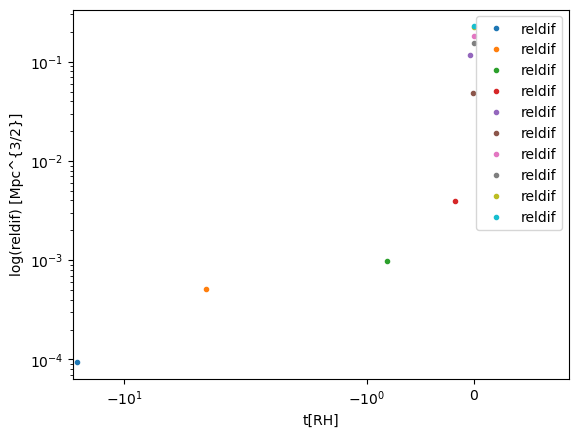

k 4.641588833612782e+05
Numerical delta =  5.261052681047827e-50, Analitical delta  5.261483757427433e-50, k_rh 464158.8833612782 

k 4.641588833612782e+05
Numerical delta =  8.775262762826666e-50, Analitical delta  8.779636675226779e-50, k_rh 464158.8833612782 

k 4.641588833612782e+05
Numerical delta =  1.464482008321603e-49, Analitical delta  1.465910134249602e-49, k_rh 464158.8833612782 

k 4.641588833612782e+05
Numerical delta =  2.441944504522721e-49, Analitical delta  2.451726393360968e-49, k_rh 464158.8833612782 

k 4.641588833612782e+05
Numerical delta =  3.683730084592904e-49, Analitical delta  4.120069814406583e-49, k_rh 464158.8833612782 

k 4.641588833612782e+05
Numerical delta =  6.474886087356687e-49, Analitical delta  7.018984386823593e-49, k_rh 464158.8833612782 

k 4.641588833612782e+05
Numerical delta =  1.046379128210764e-48, Analitical delta  1.245166534789377e-48, k_rh 464158.8833612782 

k 4.641588833612782e+05
Numerical delta =  2.768934024678801e-48, Analitical

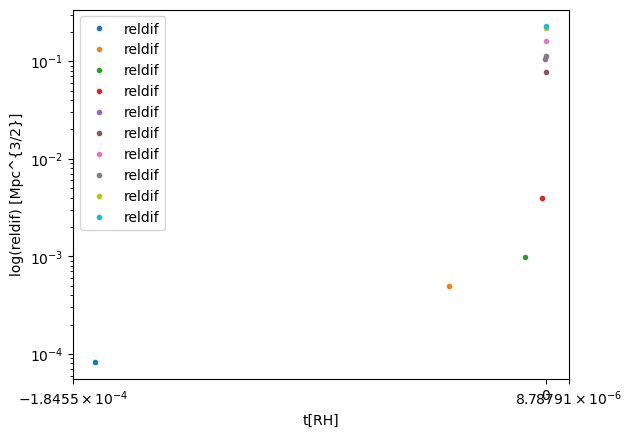

k 2.154434690031886e+07
Numerical delta =  1.663678524831807e-47, Analitical delta  1.663795674547019e-47, k_rh 21544346.900318865 

k 2.154434690031886e+07
Numerical delta =  2.774962304317704e-47, Analitical delta  2.776312203515432e-47, k_rh 21544346.900318865 

k 2.154434690031886e+07
Numerical delta =  4.631066069506686e-47, Analitical delta  4.635526931941661e-47, k_rh 21544346.900318865 

k 2.154434690031886e+07
Numerical delta =  7.716753903608710e-47, Analitical delta  7.752892693705288e-47, k_rh 21544346.900318865 

k 2.154434690031886e+07
Numerical delta =  1.234077977944961e-46, Analitical delta  1.302855864565613e-46, k_rh 21544346.900318865 

k 2.154434690031886e+07
Numerical delta =  2.633343596390835e-46, Analitical delta  2.219556219809950e-46, k_rh 21544346.900318865 

k 2.154434690031886e+07
Numerical delta =  3.840215091252359e-46, Analitical delta  3.937490714774796e-46, k_rh 21544346.900318865 

k 2.154434690031886e+07
Numerical delta =  9.347596430785283e-46, Ana

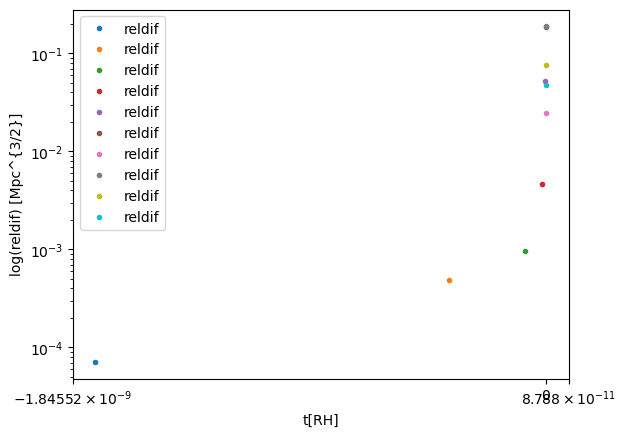

k 1.000000000000000e+09
Numerical delta =  5.261053281107944e-45, Analitical delta  5.261363216579827e-45, k_rh 1000000000.0 

k 1.000000000000000e+09
Numerical delta =  8.775267335512215e-45, Analitical delta  8.779435670880631e-45, k_rh 1000000000.0 

k 1.000000000000000e+09
Numerical delta =  1.464482818494446e-44, Analitical delta  1.465876637212414e-44, k_rh 1000000000.0 

k 1.000000000000000e+09
Numerical delta =  2.440267966008394e-44, Analitical delta  2.451670669974290e-44, k_rh 1000000000.0 

k 1.000000000000000e+09
Numerical delta =  3.667286242115482e-44, Analitical delta  4.119977602023007e-44, k_rh 1000000000.0 

k 1.000000000000000e+09
Numerical delta =  6.480972002353546e-44, Analitical delta  7.018834366398519e-44, k_rh 1000000000.0 

k 1.000000000000000e+09
Numerical delta =  1.034915367043970e-43, Analitical delta  1.245143679064388e-43, k_rh 1000000000.0 

k 1.000000000000000e+09
Numerical delta =  2.807755678824451e-43, Analitical delta  2.486613821343891e-43, k_rh

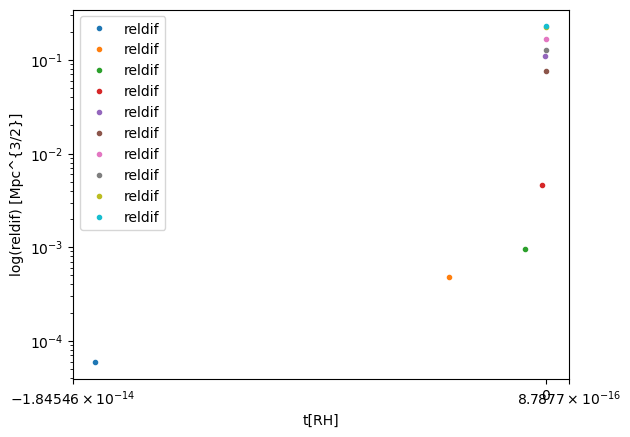

In [22]:

k_natural = []   

for k_rh in momenta_rh:
    analitical_delta_l = []
    numerical_delta_l = []

    ## Since we have different momenta, they will have different time intervals where the addiabatic aproxximation is valid.This is why I am callign this get_adiab_time function
    eta_a = get_adiab_time(k_rh)
    finalt = eta_a[0]/1000000
    times = np.geomspace(eta_a[0], finalt, 10)
    k = k_rh / csq1d.RH
    for t_rh in times:

        ## Numerical
        delta_num = compute_delta_num(k_rh, t_rh) 
        numerical_delta_l.append(delta_num)

        ###Analitical
        delta_analitical = do_analitical_delta(k_rh, t_rh) 
        analitical_delta_l.append(delta_analitical)
        print(f'Numerical delta = {delta_num:22.15e}, Analitical delta {delta_analitical:22.15e}, k_rh {k_rh} \n')
        reldif = abs(1 - delta_num/delta_analitical)
        plt.plot(t_rh, abs(1 - delta_num/delta_analitical), '.', label='reldif')

    plt.yscale('log')
    plt.xscale('symlog')
    plt.ylabel('log(reldif) [Mpc^{3/2}]')
    plt.xlabel('t[RH]')
    plt.legend()
    plt.show()

## Integral Comparison

Let us now integrate the variances filtered with a top hat $W$ in a given scale $r$. Explicitely, we want to compute
\begin{align}
	\sigma(r)^2=\frac{1}{2 \pi^{2}} \int_{ki}^{kf} \mathrm{d} k_a~~   \delta^2_{k_a} k_a^2 W(kr)\\
 \sigma(r)^2=\frac{1}{2 \pi^{2}} \int_{ki}^{kf} \mathrm{d} k_a~~   \delta^2_{k_a} k_a^2 \left| 3 \frac{\sin(kr) - kr \cos(kr)}{(kr)^3}\right|^2\\
  \sigma(r)^2=\frac{9}{2 r^2 \pi^{2}} \int_{ki}^{kf} \mathrm{d} k_a~~   \delta^2_{k_a} \left| j_1(kr)\right|^2
	,\end{align}
 where $j_1$ is the first bessel function.

In [23]:
####Scales and time
t_integral = -1.52e-21
H_natural = csq1d.H_t(t_integral)  * conv_Hrh_Hn

kj_natural = csq1d.y_t(t_integral) * H_natural * math.sqrt(3.0/2.0) /  math.sqrt(csq1d.b)
kh_natural = csq1d.y_t(t_integral) *  H_natural
r_nat = math.pi /kj_natural

kj_rh = kj_natural * conv_knat_krh 
kh_rh = kh_natural * conv_knat_krh 
print(f'kj {kj_rh:22.15e} kh {kh_rh:22.15e}')
######Parameters for integrator object

lk = np.log((kj_rh - kh_rh)/2.0)


k_interval_center =  np.log(kh_rh) + lk/2.0


knots_int = 40
lnr = np.log(10 * math.pi /kh_rh)
print(f"lk{lk:22.15e}")
print(np.exp(lnr))

kj  6.229410928216315e+09 kh  5.086292724082434e+06
lk 2.185858360056112e+01
6.176586413745068e-06


### Integration With FFtlog and Numerical Variance

This object will compute the integral for a momentum interval (kj,kh), a fixed time $t$ and a range of $r$.

In [24]:
fft = Ncm.FftlogSBesselJ.new(ell=1,lnr0=0.0 , lnk0=k_interval_center, Lk=lk, N=knots_int)
fft.set_q(0)
##This function sets the best scale for r to perform the integral
fft.set_best_lnr0()
np.exp(fft.get_lnr0())

6.104191594255408e-12

k 5.086292724082430e+06
k 8.784719662748050e+06
k 1.517240625724971e+07
k 2.620481022419100e+07
k 4.525927313327400e+07
k 7.816892345441651e+07
k 1.350083678107107e+08
k 2.331778227640691e+08
k 4.027298300889338e+08
k 6.955692188942332e+08
k 1.201342692112705e+09
k 2.074882304577742e+09
k 3.583604084092562e+09
k 6.189371899886320e+09
k 1.068988750324045e+10
k 1.846289036760503e+10
k 3.188792404249999e+10
k 5.507478403946970e+10
k 9.512164645624338e+10
k 1.642880273132279e+11
Adiabatic time not found
k 2.837477790177639e+11
Adiabatic time not found
k 4.900710259549824e+11
Adiabatic time not found
k 8.464193492965895e+11
Adiabatic time not found
k 1.461881394574579e+12
Adiabatic time not found
k 2.524868097095530e+12
Adiabatic time not found
k 4.360790780558468e+12
Adiabatic time not found
k 7.531679082039705e+12
Adiabatic time not found
k 1.300823466416561e+13
Adiabatic time not found
k 2.246699138861517e+13
Adiabatic time not found
k 3.880355137247115e+13
Adiabatic time not found
k 6.7

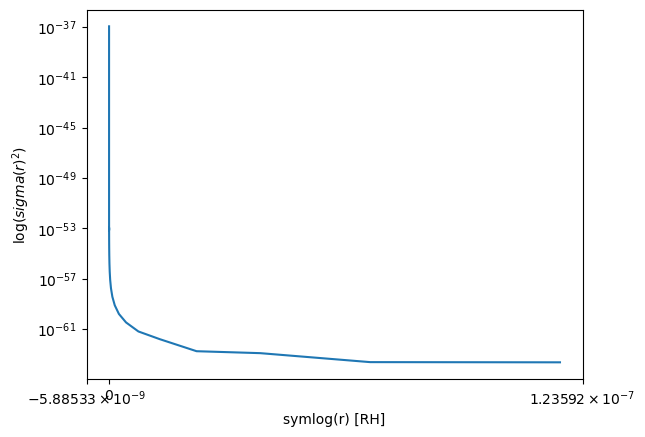

In [25]:
vec_k_knots = Ncm.Vector.new(knots_int) ## Empty vector for integrator object with the size of the knots
fft.get_lnk_vector(vec_k_knots) 

fft.eval_by_function(lambda k, _: integrand_numerical(k ,  t_integral), None)
fft.prepare_splines()
lnr_vec = fft.get_vector_lnr()
#This function computes the ingral. The argument defines if we want the derivative arg = (1,2,3), or just the integral arg = 0
integral_result = fft.get_vector_Gr(0)
var2_num_l = []
r_l = []
for i in range(0, knots_int):
    r = np.exp(lnr_vec.get(i))
    var2 = abs(integral_result.get(i))*9/(r**2)
    r_l.append(r)
    var2_num_l.append(var2)
    print(f'time = {t_integral}, var^2 = {var2}, r = {r: 22.15e}')
plt.plot(r_l, var2_num_l, label='var2')
plt.xlabel('symlog(r) [RH]')
plt.ylabel('log($ sigma(r)^2$)')
plt.xscale('symlog')
plt.yscale('log')
plt.show()


### Integration With FFtlog and Analitical Variance

In [26]:
fft_a = Ncm.FftlogSBesselJ.new(ell=1,lnr0=lnr , lnk0=k_interval_center, Lk=lk, N=knots_int)
fft_a.set_q(0)
fft_a.set_best_lnr0()
np.exp(fft_a.get_lnr0())

6.104191594255408e-12

time = -1.52e-21, var^2 = 1.5979251534718153e-37, r =  6.532286208315789e-17
time = -1.52e-21, var^2 = 3.0612694537212145e-38, r =  1.128214717670265e-16
time = -1.52e-21, var^2 = 6.040388692050277e-39, r =  1.948580341668723e-16
time = -1.52e-21, var^2 = 1.100126819526297e-39, r =  3.365463407336559e-16
time = -1.52e-21, var^2 = 2.1679392264004394e-40, r =  5.812613267165407e-16
time = -1.52e-21, var^2 = 4.0272390907656807e-41, r =  1.003917407628748e-15
time = -1.52e-21, var^2 = 7.613295142563474e-42, r =  1.733901973202361e-15
time = -1.52e-21, var^2 = 1.4051561879981961e-42, r =  2.994684652172905e-15
time = -1.52e-21, var^2 = 2.595830384123123e-43, r =  5.172227902478600e-15
time = -1.52e-21, var^2 = 4.72192381029794e-44, r =  8.933141409653099e-15
time = -1.52e-21, var^2 = 8.526829663494687e-45, r =  1.542875081096421e-14
time = -1.52e-21, var^2 = 1.517024356776133e-45, r =  2.664755215109412e-14
time = -1.52e-21, var^2 = 2.662354096138094e-46, r =  4.602394868809892e-14
time = -

<>:19: SyntaxWarning: invalid escape sequence '\s'
<>:19: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_3640/2613548571.py:19: SyntaxWarning: invalid escape sequence '\s'
  plt.ylabel('log($\sigma(r)^2$)')


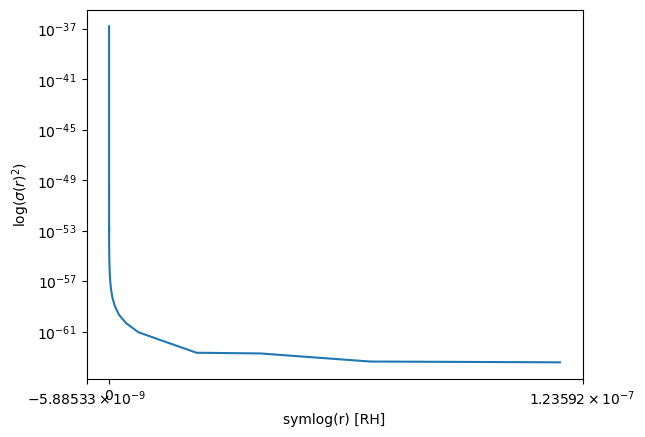

In [27]:
vec_k_knots_a = Ncm.Vector.new(knots_int) ## Empty vector for integrator object with the size of the knots
fft_a.get_lnk_vector(vec_k_knots) 

fft_a.eval_by_function(lambda k, _: integrand_analitical(k,  t_integral), None)
fft_a.prepare_splines()
lnr_vec_a = fft_a.get_vector_lnr()
#This function computes the ingral. The argument defines if we want the derivative arg = (1,2,3), or just the integral arg = 0
integral_result_a = fft_a.get_vector_Gr(0)
var2_analitical_l = []
r_l_a = []
for i in range(0, knots_int):
    r = np.exp(lnr_vec_a.get(i))
    var2 = abs(integral_result_a.get(i)) * 9 / (r**2)
    r_l_a.append(r)
    var2_analitical_l.append(var2)
    print(f'time = {t_integral}, var^2 = {var2}, r = {r: 22.15e}')
plt.plot(r_l, var2_analitical_l, label='var')
plt.xlabel('symlog(r) [RH]')
plt.ylabel('log($\sigma(r)^2$)')
plt.xscale('symlog')
plt.yscale('log')
plt.show()

### Relative difference plot for the variances

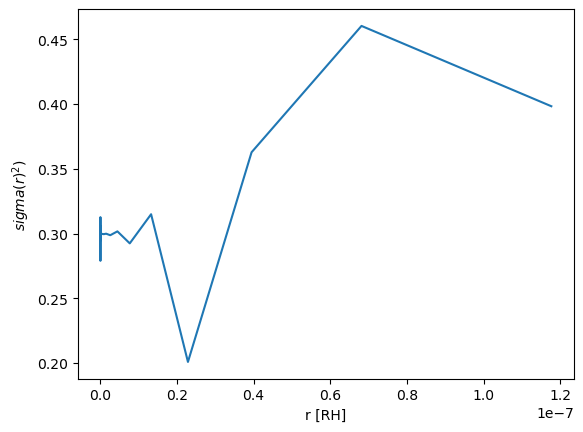

In [28]:
reldif_l = []
for i in range(0, len(var2_num_l)):
    reldif = abs(1 -var2_num_l[i] / var2_analitical_l[i] )
    reldif_l.append(reldif)

plt.plot(r_l,reldif_l,label='reldif' )
plt.xlabel('r [RH]')
plt.ylabel('$sigma(r)^2$)')
plt.show()

### Integration With 1d integral and Numerical Variance

To check if we are performing the right integral, let us integrate one time using a normal 1d integration object for a given $r$

In [29]:
class VarianceIntegrator(Ncm.Integral1d):
    
    def __init__(self, r):
        super().__init__()
        self.r = r
        self.lnr = np.log(r)
    
    def do_integrand(self, lnk, _):
        k = np.exp(lnk)
        kr = np.exp(lnk + self.lnr)
        r = np.exp(self.lnr)
        r2 = r**2
        res = integrand_analitical(k,t_integral) * k * Ncm.sf_sbessel(1, kr)**2
        return (9.0  / ( 2* math.pi**2 * r2)) * abs(res) 

var1d = VarianceIntegrator(r_l[-2])
var1d.set_reltol(1.0e-7)
val, err = var1d.eval(np.log(kh_rh), k_interval_center + lk/2)
print(f"This integral gave var2: {val:22.15e}, while the fftlog gave var2: {var2_analitical_l[-2]:22.15e}")



This integral gave var2:  2.195360947115678e-66, while the fftlog gave var2:  4.301091066417977e-64


## Beta

In [30]:
def do_beta(var, deltac):
    x = deltac / (math.sqrt(2.0) * var)
    return scipy.special.erfc(x)

In [31]:
def do_deltac(r,t_rh):
    H_eta = csq1d.H_t(t_rh) * (csq1d.y_t(t_rh) )
    return (1 / (r*H_eta))**2

In [32]:
####Scales and time
tl = -1.52e-21
H_natural = csq1d.H_t(tl)  * conv_Hrh_Hn
H_rh = csq1d.H_t(tl) * csq1d.RH
kj_natural = csq1d.y_t(tl) * H_natural * math.sqrt(3.0/2.0) /  math.sqrt(csq1d.b)
kh_natural = csq1d.y_t(tl) *  H_natural
r_nat = math.pi /kj_natural

kj_rh = kj_natural * conv_knat_krh
kh_rh = kh_natural * conv_knat_krh
rj_rh = math.pi / kj_rh
rh_rh = math.pi / kh_rh

deltac_jeans = do_deltac(rj_rh, tl)
deltac_hubble = do_deltac(rh_rh, tl)
print(deltac_jeans, deltac_hubble)

151981.7754635067 0.10132118364233779


In [33]:
deltac_list = []
r_scale_l = []
r_h = math.pi / kh_rh
r_j = math.pi / kj_rh
print(r_h, r_j)
deltac_kj_rh = do_deltac(r_j, tl)
deltac_kh_rh = do_deltac(r_h, tl)
print(deltac_kh_rh, deltac_kj_rh)

6.176586413745064e-07 5.043161688627489e-10
0.10132118364233779 151981.7754635067


In [34]:
deltac_interp = np.interp(r_l, [r_j, r_h], [deltac_kj_rh, deltac_kh_rh])

In [35]:
for i,delta in enumerate(deltac_interp):
    var = math.sqrt(var2_num_l[i])
    beta = do_beta(var, delta)
    print(f'For var = {var}, deltac = {delta}, beta = {beta}')

For var = 3.3404227072378134e-19, deltac = 151981.7754635067, beta = 0.0
For var = 1.4694016119476724e-19, deltac = 151981.7754635067, beta = 0.0
For var = 6.44344691163421e-20, deltac = 151981.7754635067, beta = 0.0
For var = 2.8164932986382925e-20, deltac = 151981.7754635067, beta = 0.0
For var = 1.2270636522156183e-20, deltac = 151981.7754635067, beta = 0.0
For var = 5.327546242501701e-21, deltac = 151981.7754635067, beta = 0.0
For var = 2.3046124231582507e-21, deltac = 151981.7754635067, beta = 0.0
For var = 9.930180423452204e-22, deltac = 151981.7754635067, beta = 0.0
For var = 4.260337187384e-22, deltac = 151981.7754635067, beta = 0.0
For var = 1.819056393443388e-22, deltac = 151981.7754635067, beta = 0.0
For var = 7.724702568406883e-23, deltac = 151981.7754635067, beta = 0.0
For var = 3.2596468572631196e-23, deltac = 151981.7754635067, beta = 0.0
For var = 1.3651740473984094e-23, deltac = 151981.7754635067, beta = 0.0
For var = 5.6648420232657475e-24, deltac = 151981.7754635067,